# Anomaly detection using RetinaNet, HOG and One-class SVM

## Import RetinaNet and some libraries

In [4]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet.keras_retinanet import models
from keras_retinanet.keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go

import cv2
import os
import numpy as np
import time

from scipy.ndimage.filters import gaussian_filter1d

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

from skimage.feature import hog, ORB
from skimage import img_as_ubyte
from skimage.transform import resize
from skimage.io import imread
from skimage import data, exposure

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import re
import glob
import pandas as pd
import pickle

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('keras_retinanet', 'model', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 
                   7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 
                   13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 
                   21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 
                   28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 
                   34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 
                   39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 
                   46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 
                   53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 
                   60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 
                   67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 
                   73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

/home/travail/jules/anaconda3/envs/retnet/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



## Some descriptors

In [21]:
def get_flow(boxes, img1, img2):
    """
        For each box, returns the flow
        box format : xmin, ymin, xmax, ymax
    """
    flows = []
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 10,
                           qualityLevel = 0.3,
                           minDistance = 1,
                           blockSize = 5 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (25,25),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # For each box, compute its flow
    # We try to find a good salient point.
    # If we don't, we use the center of the box as a fallback
    for box in boxes:
        frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        p0 = cv2.goodFeaturesToTrack(frame_gray[int(box[1]):int(box[3]),
                                                int(box[0]):int(box[2])],
                                         mask = None, **feature_params)
        
        x = (box[2] + box[0]) / 2
        y = (box[3] + box[1]) / 2
        if p0 is None:
            p0 = np.asarray([[[x, y]]], dtype=np.float32)
        else:
            p0 = p0[len(p0)//2]
            
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, p0, None, **lk_params)
        flows.append([p1.ravel()[0]- p0.ravel()[0], p1.ravel()[1]- p0.ravel()[1]])
        
    return flows

In [22]:
def get_hog(image):
    """
        Returns flattened hog
    """
    image = resize(image, (30,30))
    return hog(image, 
             orientations=8,
             pixels_per_cell=(4, 4),
             cells_per_block=(1, 1),
             multichannel=True) 


# By Mehdi
def get_hog(image):
    """
        Returns flattened hog
    """
    image = resize(image, (32,32), mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    return hog(image, 
             orientations=8,
             pixels_per_cell=(8,8),
             cells_per_block=(2,2),
             multichannel=True, block_norm="L2-Hys") 

In [23]:
def get_orb(image):
    """
        Returns ORB descriptor
    """
    desc = ORB()
    desc.detect_and_extract(image)
    return desc.descriptors

In [24]:
"""
Computes PCA
TODO Scale data ?
"""
def get_PCA(vec):
    pca = PCA(n_components = 100)
    pca.fit(vec)
    return pca.transform(vec)

def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)

angle = lambda xy : np.arctan(xy[0]/xy[1])
mag = lambda xy : np.sqrt(xy[0]**2 + xy[1]**2)

In [25]:
# Version de Jules
def make_dict(video, p = True):
    res = []
    i = 0

    images = natural_sort(glob.glob(video + '/*.tif'))
    # Init first image for flow computation
    old_img = read_image_bgr(images[0])
    for img in images[3::3]:
        image = read_image_bgr(img)

        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

        # preprocess image for network
        image = preprocess_image(image)
        image, scale = resize_image(image)

        # process image
        boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

        # correct for image scale
        boxes /= scale

        flows = get_flow(boxes[0], draw, old_img)
        # visualize detections
        for box, score, label, flow in zip(boxes[0], scores[0], labels[0], flows):
            # scores are sorted so we can break
            if score < 0.5:
                break

            #flow = scale_flow(box, flow)
            hog_box = get_hog(draw[int(box[1]):int(box[3]), int(box[0]):int(box[2])])
            #pca_hog = get_PCA(hog_box)
            object = {}
            object['label'] = label
            object['box'] = box
            object['frame'] = i
            object['hog'] = hog_box
            object['video'] = video
            object['flow_angle'] = angle(flow) 
            object['flow_mag'] = mag(flow)
    
            res.append(object)

            if p:
                color = label_color(label)
                b = box.astype(int)
                draw_box(draw, b, color=color)
                x = (box[2] + box[0]) / 2
                y = (box[3] + box[1]) / 2
                draw = cv2.line(draw, (int(x),int(y)),(int(x+flow[0]),int(y+flow[1])), (0,255,0) , 1)
                caption = "{} {:.3f}".format(labels_to_names[label], score)
                #draw_caption(draw, b, caption)

        old_img = draw
        print('\r',  (i/len(images))*100 , end='')
        i+=3

        if p:
            plt.figure(figsize=(15, 15))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
            
    return res

In [26]:
# Version de Mehdi
# Only works for two images
# Here we compute the flow
def make_dict_image(image_name_current, image_name_old):

    res = []
    
    # Init first image for flow computation
    old_img = read_image_bgr(image_name_old)
    image = read_image_bgr(image_name_current)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image_retina = preprocess_image(image)
    image_retina, scale = resize_image(image_retina)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image_retina, axis=0))
    print("processing time: ", time.time() - start)
    
    # correct for image scale
    boxes /= scale

    # Compute flows
    flows = get_flow(boxes[0], image, old_img) #BUG1 @Mehdi : draw or image
    
    # visualize detections
    for box, score, label, flow in zip(boxes[0], scores[0], labels[0], flows):
        # scores are sorted so we can break
        if score < 0.5:
            break

        #flow = scale_flow(box, flow)
        hog_box = get_hog(image[int(box[1]):int(box[3]), int(box[0]):int(box[2])]) #BUG2 @Mehdi : draw or image
        
        #pca_hog = get_PCA(hog_box) 
        object = {}
        object['label'] = labels_to_names[label]
        object['box'] = box
        #object['frame'] = i
        object['hog'] = hog_box
        #object['video'] = video
        object['flow_angle'] = angle(flow) 
        object['flow_mag'] = mag(flow)

        res.append(object)

        color = label_color(label)
        b = box.astype(int)
        draw_box(draw, b, color=color)
        x = (box[2] + box[0]) / 2
        y = (box[3] + box[1]) / 2
        draw = cv2.line(draw, (int(x),int(y)),(int(x+flow[0]),int(y+flow[1])), (0,255,0) , 1)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        #draw_caption(draw, b, caption)

    old_img = image #BUG1 @Mehdi : draw or image

    plt.figure(figsize=(15, 15))
    #plt.axis('off')
    plt.imshow(draw)
    plt.show()
            
    return res

In [27]:
# Version de Mehdi
# Here, we work with a clip (=video)
# And we do not exploit the flow
def make_dict_clip(clip_name):
    res = []

    images = natural_sort(glob.glob(clip_name + '/*.tif'))
    
    #i = 3 #current image index
   
    for idx, img in enumerate(images): #[:-3]
        
        image = read_image_bgr(img)
        #old_img = read_image_bgr(images[i-3])

        # copy to draw on
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

        # preprocess image for network
        image_retina = preprocess_image(image)
        image_retina, scale = resize_image(image_retina)

        # process image
        boxes, scores, labels = model.predict_on_batch(np.expand_dims(image_retina, axis=0))
    
        # correct for image scale
        boxes /= scale

        #flows = get_flow(boxes[0], image, old_img)
        # visualize detections
        #for box, score, label, flow in zip(boxes[0], scores[0], labels[0], flows):
        for box, score, label in zip(boxes[0], scores[0], labels[0]):

            # scores are sorted so we can break
            if score < 0.5:
                break

            #flow = scale_flow(box, flow)
            hog_box = get_hog(image[int(box[1]):int(box[3]), int(box[0]):int(box[2])])

            object = {}
            object['label'] = labels_to_names[label]
            object['box'] = box.astype(int)
            object['frame'] = idx+1
            object['hog'] = hog_box
            object['clip'] = int(clip_name[-3:]) #number of the video
            object['confidenceRetina'] = score
            #object['flow'] = flow 
            #object['flow_angle'] = angle(flow) 
            #object['flow_mag'] = mag(flow)
    
            res.append(object)

        print('\r%3.1f%%' % ((idx+1)/len(images)*100) , end='')
        #i+=1

    return res

processing time:  4.162806749343872


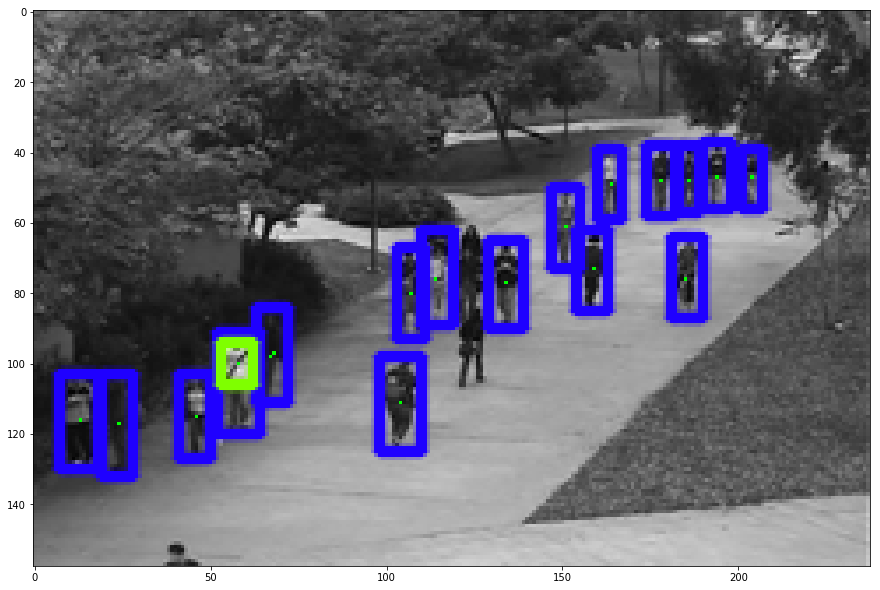

In [92]:
image_name_current = "../data/UCSDped1/Test/Test007/113.tif"
image_name_old     = "../data/UCSDped1/Test/Test007/111.tif"

my_res = make_dict_image(image_name_current, image_name_old)

## Some diagnostic by Mehdi

In [59]:
# Number of detected objects
n_boxes = len(my_res)

# Studied box
num_box = 0

### Size and class of detected bounding boxes

In [60]:
for idx in range(n_boxes) :
    
    # Integer box
    box_int = my_res[idx]['box'].astype(int)
    
    # Label
    label = my_res[idx]['label']
    
    # Size and class
    print("Box n°%2.0f\t%10s\t%.0fx%.0f" %(idx, label, box_int[2]-box_int[0], box_int[3]-box_int[1]))

Box n° 0	    person	7x21
Box n° 1	    person	10x22
Box n° 2	    person	9x21
Box n° 3	    person	11x27
Box n° 4	    person	12x27
Box n° 5	    person	8x22
Box n° 6	    person	7x18
Box n° 7	    person	13x43
Box n° 8	   bicycle	9x20
Box n° 9	    person	10x23
Box n°10	    person	14x25
Box n°11	    person	10x22
Box n°12	    person	6x15
Box n°13	    person	8x23
Box n°14	    person	11x28
Box n°15	   handbag	10x12
Box n°16	    person	9x26
Box n°17	    person	9x24


### HOG

Text(0.5, 1.0, 'Histogram of Oriented Gradients - resized')

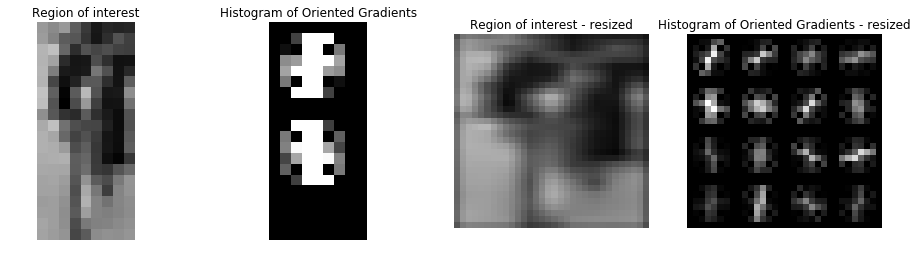

In [61]:
num_box = 8

# Open the current image
image = read_image_bgr(image_name_current)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
# HOG image and the histogram
box_int = my_res[num_box]['box'].astype(int)
region_of_interest = image[box_int[1]:box_int[3], box_int[0]:box_int[2]]
fd_0, hog_image = hog(region_of_interest, 
                      orientations=8, pixels_per_cell=(8, 8), 
                      cells_per_block=(2,2), 
                      visualize=True, block_norm="L2-Hys")

# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(16,4))

# Original image
ax1.axis('off')
ax1.imshow(region_of_interest, cmap=plt.cm.gray)
ax1.set_title('Region of interest')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

# == Get the resized version ==
image_resized = resize(region_of_interest, (32,32), mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)

# HOG image and the histogram
fd_0_rsz, hog_image_rsz = hog(image_resized, 
                      orientations=8, pixels_per_cell=(8,8), 
                      cells_per_block=(2,2), 
                      visualize=True, multichannel=True, block_norm="L2-Hys")

# Original image
ax3.axis('off')
ax3.imshow(image_resized, cmap=plt.cm.gray)
ax3.set_title('Region of interest - resized')

# Rescale histogram for better display
hog_image_rescaled_rsz = exposure.rescale_intensity(hog_image_rsz, in_range=(0, 10))
ax4.axis('off')
ax4.imshow(hog_image_rescaled_rsz, cmap=plt.cm.gray)
ax4.set_title('Histogram of Oriented Gradients - resized')



In [62]:
# Size of the HOG vector
len(fd_0_rsz)

288

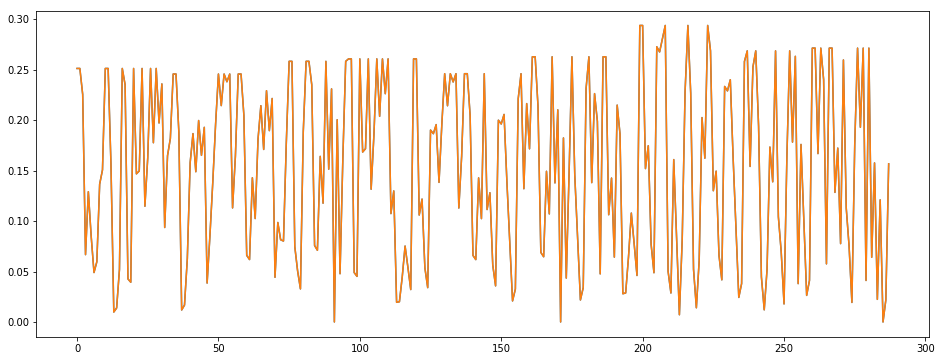

In [63]:
plt.figure(figsize=(16,6))

# Comparison of HOG vector
plt.plot(fd_0_rsz) #version from Mehdi
plt.plot(my_res[num_box]['hog']) #version from Jules

# It is the same ! 

In [64]:
# PCA on HOG vectors
boxes_HOG = np.array([my_res[i]['hog'] for i in range(n_boxes)])
boxes_label = [my_res[i]['label'] for i in range(n_boxes)]

my_colors = ['red' if x == 'person' else 'blue' for x in boxes_label]

No handles with labels found to put in legend.


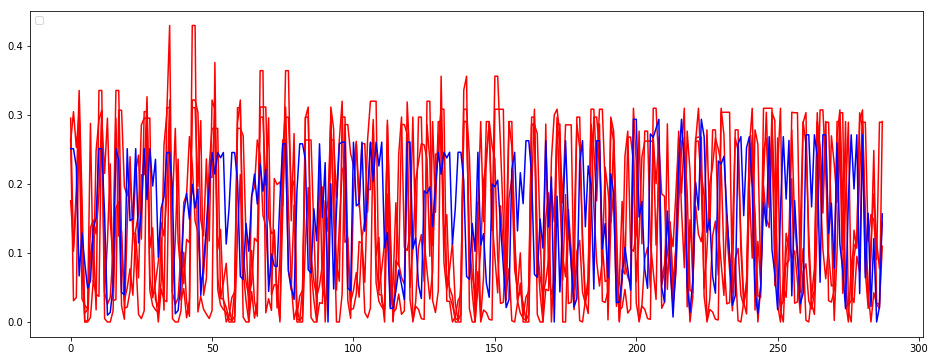

In [65]:
plt.figure(figsize=(16,6))

for idx in [0,1,2,3, 8] : 
    plt.plot(boxes_HOG[idx], c = my_colors[idx])
plt.legend(loc=2)    

0.8017154296078073


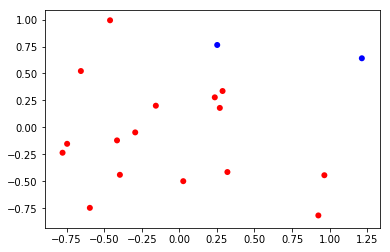

In [66]:
# Fit the PCA
pca = PCA(n_components=10)
projected = pca.fit_transform(boxes_HOG)

print(sum(pca.explained_variance_ratio_))

# Plot the boxes
for idx in range(n_boxes) : 
    plt.scatter(projected[idx, 0], projected[idx, 1], edgecolor='none', label = boxes_label[idx], 
            c = my_colors[idx])


In [67]:
pd.DataFrame(projected, columns=list('abcdefghij'))

,a,b,c,d,e,f,g,h,i,j
0,-0.746949,-0.152690,0.132827,0.353432,1.006330,0.153511,-0.235531,0.325884,0.206287,-0.112238
1,-0.461178,0.993200,0.030033,0.440022,-0.415692,0.837596,0.388990,-0.278089,0.087816,-0.523390
2,0.026100,-0.499137,0.191419,-0.608372,0.060973,0.428329,0.116058,-0.198418,0.153986,-0.239317
3,-0.395692,-0.440171,0.303331,-0.433406,-0.499310,0.455379,-0.265021,0.096542,0.202444,-0.019522
4,0.236024,0.278432,-0.186875,-0.315292,-0.123492,0.100928,0.013719,-0.216043,0.895985,0.737748
5,-0.293678,-0.046679,-0.179818,-0.446396,0.156945,-0.526330,0.382444,0.051123,0.111131,-0.207851
6,-0.156378,0.200865,-0.402679,-0.578266,0.359492,0.061979,0.395763,0.392456,-0.106209,-0.013774
7,0.925355,-0.817144,-0.460699,-0.096046,-0.045785,0.622637,-0.322236,-0.069879,-0.591696,-0.028422
8,0.252149,0.764139,0.285133,0.037811,-0.776437,-0.481485,-0.516864,0.336400,-0.111347,-0.109011
9,0.287714,0.337093,0.858120,-0.212122,0.247877,-0.189240,0.219725,0.197995,-0.554294,0.117205


### Flow

No handles with labels found to put in legend.


18


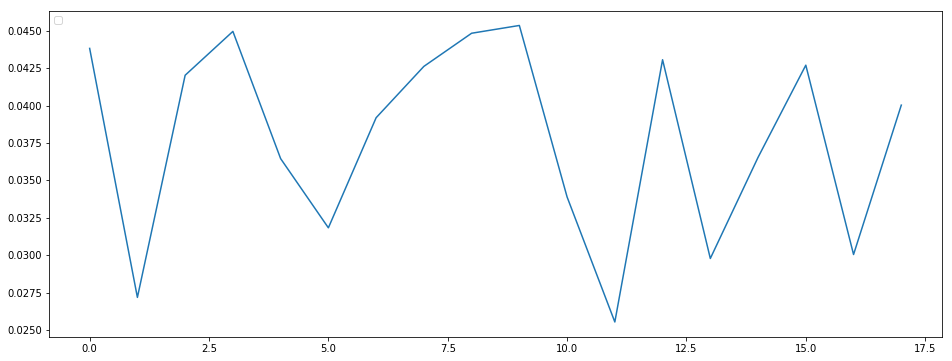

In [69]:
# Open the current image
image = read_image_bgr(image_name_current)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
# Read the flows
boxes_flow = np.array([my_res[i]['flow_mag'] for i in range(n_boxes)])
bomy_resbel = [my_res[i]['label'] for i in range(n_boxes)]
print(n_boxes)

my_colors = ['red' if x == 'person' else 'blue' for x in boxes_label]

plt.figure(figsize=(16,6))

plt.plot(boxes_flow)#, c = my_colors)
plt.legend(loc=2)    

# More meaningful on a whole dict

### on a clip

In [37]:
clip_name = "../data/UCSDped1/Test/Test007"

res_clip = make_dict_clip(clip_name)

100.0%

In [38]:
# Number of detected objects
n_boxes_clip = len(res_clip)

# PCA on HOG vectors
boxes_HOG_clip = np.array([res_clip[i]['hog'] for i in range(n_boxes_clip)])
#boxes_flowAngle_clip = np.array([res_clip[i]['flow_angle'] for i in range(n_boxes_clip)])
#boxes_flowMag_clip = np.array([res_clip[i]['flow_mag'] for i in range(n_boxes_clip)])
boxes_label_clip = [res_clip[i]['label'] for i in range(n_boxes_clip)]

my_colors_clip = ['red' if x == 'person' else 'blue' for x in boxes_label_clip]

#### PCA on HOG

0.24643590338780308


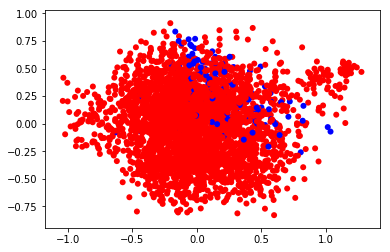

In [39]:
# Fit the PCA
pca_clip = PCA(n_components=4)
projected_clip = pca_clip.fit_transform(boxes_HOG_clip)

print(sum(pca_clip.explained_variance_ratio_))

# Plot the boxes
for idx in range(n_boxes_clip) : 
    plt.scatter(projected_clip[idx, 1], projected_clip[idx, 3], edgecolor='none', label = boxes_label_clip[idx], 
            c = my_colors_clip[idx])

In [40]:
projected_clip_df = pd.DataFrame(projected_clip, columns=list('abcd'))
projected_clip_df['class'] = ['person' if x == 'person' else 'other object' for x in boxes_label_clip]
projected_clip_df['color'] = ['red' if x == 'person' else 'blue' for x in boxes_label_clip]

In [41]:
projected_clip_df.head()

,a,b,c,d,class,color
0,0.110860,0.048617,-0.098487,-0.470246,person,red
1,-0.061340,0.310245,0.622785,-0.304382,person,red
2,0.091757,0.402283,0.138214,-0.421305,person,red
3,-0.892075,0.306961,0.119666,0.164038,person,red
4,0.091598,0.495079,0.231058,-0.642990,person,red


In [42]:
trace1 = go.Scatter3d(
    x=projected_clip_df.b,
    y=projected_clip_df.c,
    z=projected_clip_df.d,
    mode='markers',
    marker=dict(
        size=12,
        color=projected_clip_df.color,                # set color to an array/list of desired values
        opacity=0.5
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

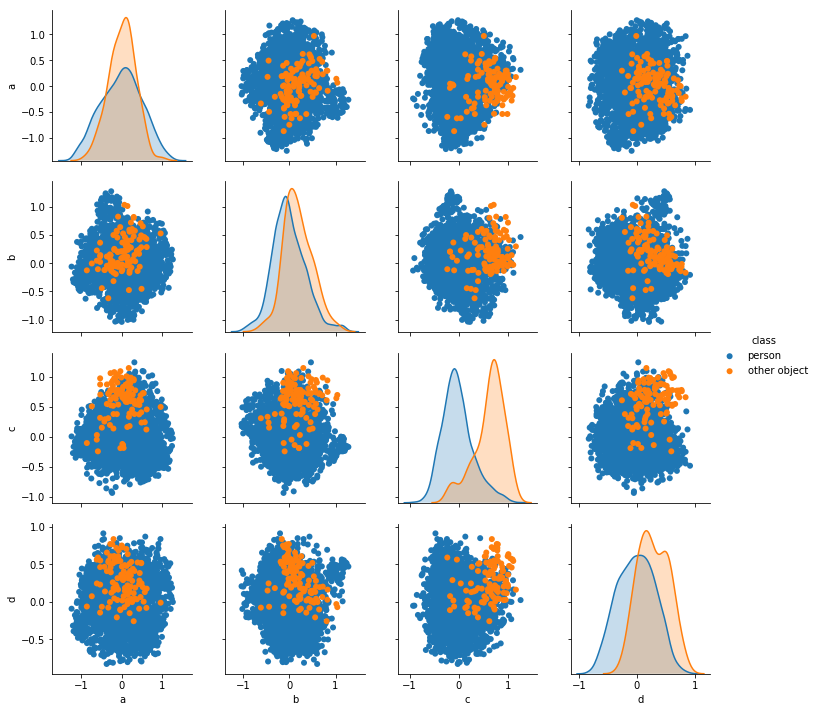

In [43]:
sns.pairplot(projected_clip_df, kind="scatter", hue="class", plot_kws=dict(edgecolor="none"))
plt.show()

## Fitting the model

In [85]:
num = "2"
videos_train_name = [folder for folder in os.listdir('../data/UCSDped' + num + '/Train/') 
               if folder.startswith('Train')]


videos_test_name = [folder for folder in os.listdir('../data/UCSDped' + num + '/Test/') 
               if folder.startswith('Test') and not folder.endswith('_gt')]

n_clip_test = len(videos_test_name)

print("Number of clips in training set : %.0f" % len(videos_train_name))
print("Number of clips in test set : %.0f" % n_clip_test)

Number of clips in training set : 16
Number of clips in test set : 12


In [86]:
to_compute = True

In [87]:
if to_compute : 
    # Getting the representation from training dataset
    objects_train = []
    for video_name in videos_train_name:
        print("\nGetting objects representation from %s" % video_name)
        objects_train += (make_dict_clip('../data/UCSDped' + num + '/Train/' + video_name))

        objects_train_df = pd.DataFrame(objects_train)
        objects_train_df.to_pickle("../results/peds" + num + "_train.pck")


Getting objects representation from Train007
100.0%
Getting objects representation from Train009
100.0%
Getting objects representation from Train001
100.0%
Getting objects representation from Train010
100.0%
Getting objects representation from Train003
100.0%
Getting objects representation from Train006
100.0%
Getting objects representation from Train012
100.0%
Getting objects representation from Train016
100.0%
Getting objects representation from Train004
100.0%
Getting objects representation from Train013
100.0%
Getting objects representation from Train002
100.0%
Getting objects representation from Train014
100.0%
Getting objects representation from Train011
100.0%
Getting objects representation from Train005
100.0%
Getting objects representation from Train008
100.0%
Getting objects representation from Train015
100.0%

In [93]:
if to_compute : 
    # Getting the representation from test dataset
    objects_test = []
    for video_name in videos_test_name: 
        print("\nGetting objects representation from %s" % video_name)
        objects_test += (make_dict_clip('../data/UCSDped' + num + '/Test/' + video_name))

        objects_test_df = pd.DataFrame(objects_test)
        objects_test_df.to_pickle("../results/peds" + num + "_test.pck")


Getting objects representation from Test001
100.0%
Getting objects representation from Test003
100.0%
Getting objects representation from Test005
100.0%
Getting objects representation from Test011
100.0%
Getting objects representation from Test006
100.0%
Getting objects representation from Test012
100.0%
Getting objects representation from Test007
100.0%
Getting objects representation from Test008
100.0%
Getting objects representation from Test009
100.0%
Getting objects representation from Test004
100.0%
Getting objects representation from Test010
100.0%
Getting objects representation from Test002
100.0%

In [94]:
# Vector of all HOG for train
objects_train = pd.read_pickle("../results/peds" + num + "_train.pck")
train_HOG = np.stack(np.asarray(objects_train["hog"]))

In [95]:
# Vector of all HOG for train
objects_test = pd.read_pickle("../results/peds" + num + "_test.pck")
test_HOG = np.stack(np.asarray(objects_test["hog"]))

In [96]:
# Number of frames per clip
n_frames_per_clip = [len([file for file in os.listdir('../data/UCSDped' + num + '/Test/' + video_name) if file.endswith('.tif')]) for video_name in videos_test_name]
n_frames_per_clip #always 200 ! 

# Have to remove 3 frames per clip ! due to the flow (?)
n_frames_per_clip = np.array(n_frames_per_clip) - 0
n_frames_per_clip

array([180, 150, 150, 180, 180, 180, 180, 180, 120, 180, 150, 180])

In [99]:
# Getting the ground truth
anomaly_test_peds = pd.read_csv("../data/UCSDped" + num + "/Test/UCSDped" + num + ".csv", delimiter=';')
anomaly_test_peds

,clip,start_anomaly,end_anomaly
0,1,61,180
1,2,95,180
2,3,1,146
3,4,31,180
4,5,1,129
5,6,1,159
6,7,46,180
7,8,1,180
8,9,1,120
9,10,1,150


In [100]:
# Creating the ground truth vector, frame per frame
gt_test_peds = np.ones(n_frames_per_clip.sum())
print("Size of the ground truth vector : %.0f " % len(gt_test_peds))

# Put anomalies
for index, row in anomaly_test_peds.iterrows():
    
    # Number of the video
    video_number = row['clip'] #3 lats number of the name
    
    # Start and end of the anomaly
    start_anomaly = (video_number-1)*n_frames_per_clip[video_number-1] + row['start_anomaly']
    end_anomaly = (video_number-1)*n_frames_per_clip[video_number-1] + row['end_anomaly'] + 1
    
    # Put ones
    gt_test_peds[start_anomaly:end_anomaly] = -1
    
    
print("Number of frames with anomaly : %.0f" % np.sum(gt_test_peds == -1))
# np.sum(anomaly_test_peds1.end_anomaly) - np.sum(anomaly_test_peds1.start_anomaly-1)

Size of the ground truth vector : 2010 
Number of frames with anomaly : 1366


In [101]:
# Quid bad detection in train : less than 3% of outlier, mainly backpack
all_classes_train = np.stack(np.asarray(objects_train["label"]))
print(np.mean(all_classes_train != "person")*100)

all_classes_test = np.stack(np.asarray(objects_test["label"]))

0.7079250344647714


In [102]:
train_HOG.shape

(26839, 288)

In [103]:
# One-Class SVM
clf = svm.OneClassSVM(gamma = "auto")
clf.fit(train_HOG)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [104]:
# Predict on test 
scores = clf.score_samples(test_HOG)

In [105]:
test_clip = np.stack(np.asarray(objects_test["clip"]))
test_frame = np.stack(np.asarray(objects_test["frame"]))
test_label = np.stack(np.asarray(objects_test["label"]))
test_confidenceRetina = np.stack(np.asarray(objects_test["confidenceRetina"]))

results_df = pd.DataFrame({'clip' : test_clip,
                           'frame' : test_frame,
                           'score' : scores,
                           'label' : test_label,
                          'confidenceRetina' : test_confidenceRetina})

In [106]:
def get_scores(group):
    
    # Score based on the SVM score
    ## We take the minimum
    svm_score = group['score'].min()
    
    # Score based on RetinaNet score
    # We take the maximum amongst abnormal objects ; by default 1
    obj_anormal = [label in ['motorcycle', 'car', 'bike', 'skate'] for label in group['label']]
    retina_score = -group.loc[obj_anormal, 'confidenceRetina'].max()
    if np.isnan(retina_score) : 
        retina_score = 1
                                             
    return  pd.Series((svm_score, retina_score), index= ['svm_score', 'retina_score'])


In [107]:
# Compute the score of abnormality for each frame
results_df = results_df.groupby(['clip', 'frame']).apply(get_scores)


In [150]:
# Choice of the anomaly vectors
results_anomaly = np.array(results_df['svm_score'])
#results_anomaly = np.array(results_df['retina_score'])

In [140]:
def filter_results(results_anomaly, sigma, n_frames_per_clip):
    """
       Block-smoothing : we cannot go out of the clip
    """
    n_clips = len(n_frames_per_clip)    
    results_smooth = np.zeros_like(results_anomaly) 
    # pour effet de bords on insère 0 au début
    n_frames_per_clip = np.insert(n_frames_per_clip, 0, 0)
    start = 1
    end = 0
    for i in range(n_clips) :
        start += n_frames_per_clip[i]
        end += n_frames_per_clip[i+1]
        results_smooth[start:end] = gaussian_filter1d(results_anomaly[start:end], sigma = sigma)    
    return results_smooth 

Evaluation for sigma = 5.0 : AUC = 0.609
Evaluation for sigma = 10.0 : AUC = 0.614
Evaluation for sigma = 15.0 : AUC = 0.616
Evaluation for sigma = 20.0 : AUC = 0.623
Evaluation for sigma = 25.0 : AUC = 0.633
Evaluation for sigma = 30.0 : AUC = 0.647
Evaluation for sigma = 35.0 : AUC = 0.658
Evaluation for sigma = 40.0 : AUC = 0.669
Evaluation for sigma = 45.0 : AUC = 0.679
Evaluation for sigma = 50.0 : AUC = 0.684
Evaluation for sigma = 55.0 : AUC = 0.686
Evaluation for sigma = 60.0 : AUC = 0.687
Evaluation for sigma = 65.0 : AUC = 0.687
Evaluation for sigma = 70.0 : AUC = 0.689
Evaluation for sigma = 75.0 : AUC = 0.689
Evaluation for sigma = 80.0 : AUC = 0.687
Evaluation for sigma = 85.0 : AUC = 0.688
Evaluation for sigma = 90.0 : AUC = 0.688
Evaluation for sigma = 95.0 : AUC = 0.688
Evaluation for sigma = 100.0 : AUC = 0.689
Evaluation for sigma = 105.0 : AUC = 0.692
Evaluation for sigma = 110.0 : AUC = 0.691
Evaluation for sigma = 115.0 : AUC = 0.688
Evaluation for sigma = 120.0 : 

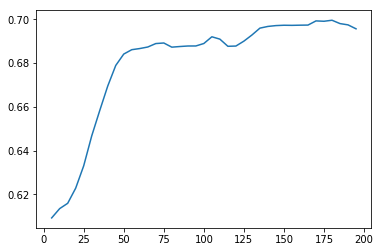

In [151]:
# What about sigma ?
auc_sigma = []
sigma_values = np.arange(5,200, 5)
for sigma in sigma_values:
    fpr, tpr, _ = roc_curve(gt_test_peds,filter_results(results_anomaly, sigma, n_frames_per_clip))
    roc_auc = auc(fpr, tpr)
    auc_sigma.append(roc_auc)
    print("Evaluation for sigma = %.1f : AUC = %.3f" %(sigma, roc_auc))

plt.plot(sigma_values, auc_sigma)

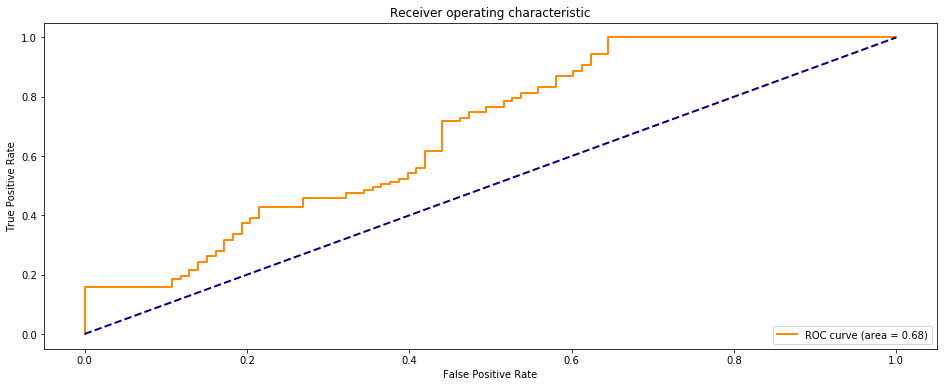

In [142]:
video_num = 0

fpr, tpr, _ = roc_curve(gt_test_peds1[(video_num*200):(video_num*200+200)], 
                        gaussian_filter1d(results_anomaly, sigma = 15)[(video_num*200):(video_num*200+200)])
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (16,6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute EER (useless)
fnr = 1 - tpr
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print(EER)